**PROGRAMA CON EL QUE SE PUEDEN ENTRENAR LOS MODELOS XY & mhe POR IGUAL**


1.   Desde MATLAB se importa directamente las matrices y tablas escaladas
2.   2000x8 en la red -> todos los sensores dentro pero manteniendo la filosofía de red
3.   Multiple target: x, y.

**RESULTADOS**

Error absoluto acumulado

*   Training loss: 0.0850 || X: 32.7501 || Y: 29.1877



# **PARAMETERS**

In [1]:
# study = 'XY'
study = 'mhe'
k = 4
load_model = False      # If = 1 --> pretrained model will be loaded, else, no

# **IMPORTS**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from __future__ import print_function, division
torch.manual_seed(0)
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, transform
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

import time

cuda


# **UTILS**

### *UTILS GENERICAS*

In [3]:
## utils_DP

import scipy.io
import numpy as np
import os
import pandas as pd
import h5py
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

###      ------      ###
def f_Get_Impact_Database_XY( data_dir ):
    """
    Load .mat file and extract fields
    Args:
        data_dir (strign): Path to X.mat and Y.csv (also contains Y.mat).
    Return:
        X (dataframe): X matrix converted to dataframe, more easy to process data with df.
        Y (dataframe): multiple targets.
    """
    # Data
    file = h5py.File(data_dir + '/X_Scaled.mat', 'r')
    X = np.transpose( file['X_Scaled'][()] )  # file['X'].value
    X = pd.DataFrame( X )
    # Labels
    Y = pd.read_csv( data_dir + '/Y_Scaled.csv', delimiter=';' ) 

    return X, Y

###      ------      ###

class C_Kfold_idx():
    """
        Class wich contains the index of test, training and validation samples
    """
    def __init__(self):
        self.training = []
        self.test = []
        self.validation = []
    def append_idx(self, att, idx):
        self.__dict__[att].append(idx)
    def get_idx(self, i):
        return self.training[i], self.test[i], self.validation[i]

def Split_kTTV_Dataset(df, train_per=0.5, test_per=0.25, val_per=0.25, kfolds=4):
    """
    Function that generates the row index that will be used for training, test and validation 
    Args:
        df (dataframe): Data or labels dataframe.
        x_per (real<1): Percentaje of the dataset that will be used to each task.
        kfolds (integer): Number of different splits combinations.
    Return:
        kTTV_Dataset (C_Kfold_idx obj): Object with the index.
    """
    if np.round(test_per + train_per + val_per, 3) != 1.0:
        print( "Train, test and validation percentajes don't sum 1" )
    idx_compleate = np.linspace( 0, len(df.index)-1, len(df.index) )
    kTTV_Dataset = C_Kfold_idx()
    for k in range(kfolds):
        # Generate training index
        idx_train, idx_tv = train_test_split(
            idx_compleate, 
            test_size=(1-train_per),
            random_state=1*k
        )
        # Generate test and validation index
        idx_val, idx_test = train_test_split(
            idx_tv, 
            test_size=test_per/(test_per+val_per),
            random_state=1*k
        )
        # Save the index in it's objet attributes
        kTTV_Dataset.append_idx( 'training', idx_train.tolist() )
        kTTV_Dataset.append_idx( 'test', idx_test.tolist() )
        kTTV_Dataset.append_idx( 'validation', idx_val.tolist() )

    return kTTV_Dataset


## utils_DT

from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
import pandas as pd
import numpy as np


class MinMaxScaleAll:
    def __init__(self) -> None:
        self.min = []
        self.min = []
        pass

    def Fit(self, val):
        # val = df.values
        self.min = np.min(val)
        self.max = np.max(val)

    def Scale(self, val):
        # val = df.values
        valnorm = ( val - self.min )/( self.max - self.min )
        return valnorm # pd.DataFrame(valnorm)

    def Inverse(self, valnorm):
        # valnorm = df.values
        val = valnorm*( self.max - self.min )  + self.min
        return val # pd.DataFrame(val)

def Normalize(x_train, y_train, x_val, y_val, x_test, y_test):
    # Fit the transform
    transX = MinMaxScaleAll()
    transX.Fit(x_train)
    # Normalize X
    x_train = transX.Scale(x_train)
    x_test = transX.Scale(x_test)
    x_val = transX.Scale(x_val)

    # Normalization of targets
    transY = MinMaxScaler( feature_range=(0,1) )
    transY.fit( y_train )
    y_train = pd.DataFrame(
        transY.transform( y_train )
        )
    y_test = pd.DataFrame(
        transY.transform( y_test )
        )
    y_val = pd.DataFrame(
        transY.transform( y_val )
        )

    # Save transforms
    # dump(transX, open('/content/drive/MyDrive/MUSE/S3/CE2/Autoencoder/10/Transforms/transX.pkl', 'wb'))
    # dump(transY, open('/content/drive/MyDrive/MUSE/S3/CE2/Autoencoder/10/Transforms/transY.pkl', 'wb'))
    # Load transform
    # transY = load(open('Transforms/transY.pkl', 'rb'))
    return x_train, y_train, x_val, y_val, x_test, y_test

## Remove wrong impacs
def f_Remove_Wrong_Impact(idx2remove, idx_train, idx_val, idx_test):
    # Loop over the wrong idx impacts
    for idx in idx2remove:
        # Find where the idx is
        intrain = idx in idx_train
        inval = idx in idx_val
        intest = idx in idx_test
        # Remove the impact
        if intrain:
            idx_train.remove(idx)
            print('Removed in training')
        elif inval:
            idx_val.remove(idx)
            print('Removed in validation')
        else:
            idx_test.remove(idx)
            print('Removed in test')

    return idx_train, idx_val, idx_test




### *UTILS PARA USAR XY - mhe*

#### DATA PREPARATION

In [4]:
def f_Data_Preparation(target, idx2remove):
    # Read dataset
    data_dir = r'/content/drive/MyDrive/MUSE/S3/CE2/Data'
    X, Y = f_Get_Impact_Database_XY( data_dir )
    print("X shape: ", X.shape)

    # Generate the k splits of datasets
    kTTV_Dataset = Split_kTTV_Dataset(Y)

    # Get the index of a single fold
    idx_train, idx_test, idx_val = kTTV_Dataset.get_idx(k-1)

    ## Split the dataset into Training, Validation and Test
    # Get idxs
    idx_train = [int(idx) for idx in idx_train]
    idx_val = [int(idx) for idx in idx_val]
    idx_test = [int(idx) for idx in idx_test]

    # Remove the wrong impacts
    print(f'Train shape: {len(idx_train)} \nVal shape: {len(idx_val)} \nTest shape: {len(idx_test)}')
    
    idx_train, idx_val, idx_test = f_Remove_Wrong_Impact(idx2remove, idx_train, idx_val, idx_test)

    # Load data and drop rows in order to empty RAM
    x_val, y_val = X.loc[idx_val].values, Y.loc[idx_val].values
    X = X.drop(idx_val)
    time.sleep(10)
    x_test, y_test = X.loc[idx_test].values, Y.loc[idx_test].values
    X = X.drop(idx_test)
    time.sleep(10)
    x_train, y_train = X.loc[idx_train].values, Y.loc[idx_train].values
    X = X.drop(idx_train)
    del X
    time.sleep(10)

    # Ceck lengths after removing the wrong impacts
    print(f'Train shape: {len(x_train)} \nVal shape: {len(x_val)} \nTest shape: {len(x_test)}')


    ## DATLOADER 
    class Impacts(Dataset):
        """Impacts dataset."""
        def __init__(self, x, y, target, transform=None):
            """
            Args:
                csv_file (string): Path to the csv file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied
                    on a sample.
            """
            all_sensors = x
            # one_sensor = all_sensors[:,0,:].reshape((-1, 2000))
            self.x = torch.from_numpy( all_sensors ).float()
            all_targets = y
            self.y = torch.from_numpy( all_targets[:,target] ).float()
            self.N = y.shape[0]
            self.target = target

        def __len__(self):
            return self.N

        def __getitem__(self, idx):
            x = self.x[idx,:].reshape(8,2000).transpose(0,1)   # --> 2000 x 8
            # x = self.x[idx,:].reshape(8,2000)   # --> 8 X 2000
            # x = self.x[idx,0]
            return x[:,:], self.y[idx]


    ## DATASETS
    ds_train = Impacts(x_train,
                    y_train,
                    target=target
    )
    ds_test = Impacts(x_test,
                    y_test,
                    target=target
    )
    ds_val = Impacts(x_val,
                    y_val,
                    target=target
    )


    ## DATALOADER

    dl_train = DataLoader(dataset=ds_train , batch_size=32,
                            shuffle=True)
    dl_test = DataLoader(dataset=ds_test , batch_size=32,
                            shuffle=True)
    dl_val = DataLoader(dataset=ds_val , batch_size=32,
                            shuffle=True)


    ## CHECK DATASET AND DATALOADER

    # Get item
    x, y = ds_val[0]
    print(y)
    fig = plt.figure()
    plt.plot(x)
    plt.title("SINGLE IMPACT")
    plt.show()

    # Plot batches
    for i_batch, sample_batched in enumerate(dl_train):
        print(i_batch, 
            sample_batched[0].size(),
            sample_batched[1].size())

        for i in range(0, 4):
            # plt.plot(sample_batched[0][i,:])
            plt.plot(sample_batched[0][i])
            plt.title("BATCH IMPACT: " + str(i+1))
            plt.show()

        # observe 4th batch and stop.
        if i_batch == 0:
            break

    return ds_train, ds_val, ds_test, dl_train, dl_val, dl_test

#### NET

In [5]:
# Weights initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Compress sensor layer
class First_Stage_Layer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in, size_out):
        super().__init__()
        # Attribute init
        self.size_in, self.size_out = size_in, size_out
        # Layer secuence
        self.FC = nn.Sequential(
            nn.Linear(self.size_in, 1500),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Linear(1500, 1000),
            nn.Tanh(),
            nn.Linear(1000, 750),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Linear(750, 500),
            nn.Tanh(),
            # nn.Dropout(p=0.2),
            nn.Linear(500, 250),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Linear(250, self.size_out)         
        ).apply(init_weights)
    def forward(self, x):
        x = self.FC(x)
        return x

class Second_Stage_Layer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self):
        super().__init__()
        # Layer secuence
        self.FC = nn.Sequential(
            nn.Linear(125*8, 500),
            nn.Tanh(),
            nn.Linear(500, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            # nn.Dropout(p=0.2),
            nn.Linear(16, 1),
            nn.ReLU()
        ).apply(init_weights)
    def forward(self, x):
        x = self.FC(x)
        return x

class XY(nn.Module):
    def __init__(self):
        super(XY, self).__init__()
        self.cs0 = First_Stage_Layer(2000, 125)
        self.cs1 = First_Stage_Layer(2000, 125)
        self.cs2 = First_Stage_Layer(2000, 125)
        self.cs3 = First_Stage_Layer(2000, 125)
        self.cs4 = First_Stage_Layer(2000, 125)
        self.cs5 = First_Stage_Layer(2000, 125)
        self.cs6 = First_Stage_Layer(2000, 125)
        self.cs7 = First_Stage_Layer(2000, 125)
        
        self.fc_x = Second_Stage_Layer()
        self.fc_y = Second_Stage_Layer()
    def forward(self, x):
        bs = x.shape[0]
        x0 = self.cs0(x[:,:,0].reshape(bs,-1))
        x1 = self.cs1(x[:,:,1].reshape(bs,-1))
        x2 = self.cs0(x[:,:,2].reshape(bs,-1))
        x3 = self.cs1(x[:,:,3].reshape(bs,-1))
        x4 = self.cs0(x[:,:,4].reshape(bs,-1))
        x5 = self.cs1(x[:,:,5].reshape(bs,-1))
        x6 = self.cs0(x[:,:,6].reshape(bs,-1))
        x7 = self.cs1(x[:,:,7].reshape(bs,-1))
        x = torch.cat((x0, x1, x2, x3, x4, x5, x6, x7), 1)
        
        X = self.fc_x(x).flatten()
        Y = self.fc_y(x).flatten()
        
        return X, Y    

class mhe(nn.Module):
    def __init__(self):
        super(mhe, self).__init__()
        self.cs0 = First_Stage_Layer(2000, 125)
        self.cs1 = First_Stage_Layer(2000, 125)
        self.cs2 = First_Stage_Layer(2000, 125)
        self.cs3 = First_Stage_Layer(2000, 125)
        self.cs4 = First_Stage_Layer(2000, 125)
        self.cs5 = First_Stage_Layer(2000, 125)
        self.cs6 = First_Stage_Layer(2000, 125)
        self.cs7 = First_Stage_Layer(2000, 125)
            
        self.fc_m = Second_Stage_Layer()
        self.fc_h = Second_Stage_Layer()
        self.fc_e = Second_Stage_Layer()

    def forward(self, x):
        bs = x.shape[0]
        x0 = self.cs0(x[:,:,0].reshape(bs,-1))
        x1 = self.cs1(x[:,:,1].reshape(bs,-1))
        x2 = self.cs0(x[:,:,2].reshape(bs,-1))
        x3 = self.cs1(x[:,:,3].reshape(bs,-1))
        x4 = self.cs0(x[:,:,4].reshape(bs,-1))
        x5 = self.cs1(x[:,:,5].reshape(bs,-1))
        x6 = self.cs0(x[:,:,6].reshape(bs,-1))
        x7 = self.cs1(x[:,:,7].reshape(bs,-1))

        x = torch.cat((x0, x1, x2, x3, x4, x5, x6, x7), 1)
            
        m = self.fc_m(x).flatten()
        h = self.fc_h(x).flatten()
        e = self.fc_e(x).flatten()

        return m, h, e

#### Training

In [6]:
def f_Training_XY(model, device, num_epochs, dl_train, dl_val):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        loss_sum = 0
        model.train()
        for (x, y) in dl_train:
            x = x.to(device)
            y = y.to(device)
            # Forward pass
            X, Y = model(x)
            # Losses
            loss_X = criterion(X, y[:,0])
            loss_Y = criterion(Y, y[:,1])
            loss = loss_X + loss_Y
            loss_sum += loss
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        else:
            with torch.no_grad():
                model.eval()
                X_sum = 0
                Y_sum = 0
                for x, y in dl_val:
                    x = x.to(device)
                    #forward pass
                    X, Y = model(x)
                    # Mean Square Error
                    X_sum += torch.sum( torch.abs( X.to('cpu') - y[:,0].to('cpu') ) )
                    Y_sum += torch.sum( torch.abs( Y.to('cpu') - y[:,1].to('cpu') ) )
                print(f'Epoch: {epoch+1} of {num_epochs} || Training loss: {loss_sum:.4f} || X: {X_sum:.4f} || Y: {Y_sum:.4f}')
    return model

def f_Training_mhe(model, device, num_epochs, dl_train, dl_val):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        loss_sum = 0
        model.train()
        for (x, y) in dl_train:
            x = x.to(device)
            y = y.to(device)
            # Forward pass
            m, h, e = model(x)
            # Losses
            loss_m = criterion(m, y[:,0])
            loss_h = criterion(h, y[:,1])
            loss_e = criterion(e, y[:,2])
            loss = loss_m + loss_h + loss_e
            loss_sum += loss
            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        else:
            with torch.no_grad():
                model.eval()
                m_sum = 0
                h_sum = 0
                e_sum = 0
                for x, y in dl_val:
                    x = x.to(device)
                    #forward pass
                    m, h, e = model(x)
                    # Mean Square Error
                    m_sum += torch.sum( torch.abs( m.to('cpu') - y[:,0].to('cpu') ) )
                    h_sum += torch.sum( torch.abs( h.to('cpu') - y[:,1].to('cpu') ) )
                    e_sum += torch.sum( torch.abs( e.to('cpu') - y[:,2].to('cpu') ) )
                print(f'Epoch: {epoch+1} of {num_epochs} || Training loss: {loss_sum:.4f} || m: {m_sum:.4f} || h: {h_sum:.4f} || e: {e_sum:.4f}')
    return model

# **Data preparation**

In [ ]:
idx2remove = [30724., 33480.]

if study == 'XY':
    target = [0, 1]  # x, y
    ds_train, ds_val, ds_test, dl_train, dl_val, dl_test = f_Data_Preparation(target, idx2remove)
else:
    target = [2, 3, 4]  # m, h, e
    ds_train, ds_val, ds_test, dl_train, dl_val, dl_test = f_Data_Preparation(target, idx2remove)

# **MODEL**

In [12]:
if study == 'XY':
    # MODEL
    model = XY().to(device)
    if load_model == True:
        model.load_state_dict(
            torch.load('/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/XY/Models/XY_model_k-0'+str(k),
                    map_location=torch.device(device)
            )
        )    
else:
    # MODEL
    model = mhe().to(device)
    if load_model == True:
        model.load_state_dict(
            torch.load('/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/mhe/Models/mhe_model_k-0'+str(k),
                    map_location=torch.device(device)
            )
        )  

# **Training**



1.   E = 30, lr = -5
2.   E = 5, lr = -6





In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4, 
                             # weight_decay=1e-5
                             )

num_epochs = 25

if study == 'XY':
    model = f_Training_XY(model, device, num_epochs, dl_train, dl_val)
else:
    model = f_Training_mhe(model, device, num_epochs, dl_train, dl_val)

Epoch: 1 of 25 || Training loss: 40.4287 || m: 1278.3572 || h: 1157.9944 || e: 552.5986
Epoch: 2 of 25 || Training loss: 30.1405 || m: 879.6658 || h: 1028.3348 || e: 489.6379
Epoch: 3 of 25 || Training loss: 26.1691 || m: 731.7497 || h: 1036.9536 || e: 520.1395
Epoch: 4 of 25 || Training loss: 23.9864 || m: 926.2618 || h: 934.3002 || e: 578.7628
Epoch: 5 of 25 || Training loss: 22.4674 || m: 643.9108 || h: 839.7978 || e: 469.4398
Epoch: 6 of 25 || Training loss: 20.8015 || m: 716.4984 || h: 1611.9392 || e: 670.1808


lr=-5

Epoch: 1 of 30 || Training loss: 126.9043 || X: 1401.7664 || Y: 2627.4524
Epoch: 2 of 30 || Training loss: 63.7489 || X: 967.5220 || Y: 1638.8867
Epoch: 3 of 30 || Training loss: 26.2807 || X: 602.7945 || Y: 776.9045
Epoch: 4 of 30 || Training loss: 11.2863 || X: 460.2082 || Y: 604.1532
Epoch: 5 of 30 || Training loss: 6.5180 || X: 369.1720 || Y: 412.6382
Epoch: 6 of 30 || Training loss: 4.5638 || X: 283.2063 || Y: 326.0634
Epoch: 7 of 30 || Training loss: 3.3182 || X: 230.0656 || Y: 280.0607
Epoch: 8 of 30 || Training loss: 2.5292 || X: 220.4413 || Y: 252.2637
Epoch: 9 of 30 || Training loss: 2.0001 || X: 178.1628 || Y: 225.7939
Epoch: 10 of 30 || Training loss: 1.5950 || X: 198.4639 || Y: 191.6835
Epoch: 11 of 30 || Training loss: 1.3101 || X: 145.7449 || Y: 147.1729
Epoch: 12 of 30 || Training loss: 1.1309 || X: 127.5649 || Y: 156.8723
Epoch: 13 of 30 || Training loss: 0.9378 || X: 114.0415 || Y: 143.1672
Epoch: 14 of 30 || Training loss: 0.7756 || X: 120.6974 || Y: 157.5181
Epoch: 15 of 30 || Training loss: 0.7106 || X: 113.2216 || Y: 126.5450
Epoch: 16 of 30 || Training loss: 0.6116 || X: 89.1048 || Y: 97.2816
Epoch: 17 of 30 || Training loss: 0.6657 || X: 86.5892 || Y: 96.8970
Epoch: 18 of 30 || Training loss: 0.4837 || X: 89.0949 || Y: 95.8440
Epoch: 19 of 30 || Training loss: 0.4411 || X: 78.3836 || Y: 86.0526
Epoch: 20 of 30 || Training loss: 0.4143 || X: 67.6185 || Y: 76.0770
Epoch: 21 of 30 || Training loss: 0.3526 || X: 76.1174 || Y: 84.8245
Epoch: 22 of 30 || Training loss: 0.3244 || X: 62.2659 || Y: 63.3064
Epoch: 23 of 30 || Training loss: 0.3419 || X: 70.2888 || Y: 66.1879
Epoch: 24 of 30 || Training loss: 0.3071 || X: 66.2137 || Y: 69.6693
Epoch: 25 of 30 || Training loss: 0.2644 || X: 63.4479 || Y: 68.7119
Epoch: 26 of 30 || Training loss: 0.2714 || X: 71.9257 || Y: 68.7995
Epoch: 27 of 30 || Training loss: 0.3286 || X: 55.6129 || Y: 54.1850
Epoch: 28 of 30 || Training loss: 0.2188 || X: 54.5939 || Y: 56.1864
Epoch: 29 of 30 || Training loss: 0.2173 || X: 47.1339 || Y: 50.5022
Epoch: 30 of 30 || Training loss: 0.2000 || X: 56.6637 || Y: 44.2348

lr=5r-6

Epoch: 1 of 30 || Training loss: 0.1571 || X: 43.8817 || Y: 43.9760
Epoch: 2 of 30 || Training loss: 0.1446 || X: 40.5366 || Y: 43.7807
Epoch: 3 of 30 || Training loss: 0.1296 || X: 43.4571 || Y: 40.6205
Epoch: 4 of 30 || Training loss: 0.1323 || X: 41.1332 || Y: 38.9967
Epoch: 5 of 30 || Training loss: 0.1317 || X: 44.0321 || Y: 42.0699
Epoch: 6 of 30 || Training loss: 0.1283 || X: 36.7220 || Y: 35.5728
Epoch: 7 of 30 || Training loss: 0.1254 || X: 39.0332 || Y: 36.3760
Epoch: 8 of 30 || Training loss: 0.1144 || X: 37.3786 || Y: 34.8523
Epoch: 9 of 30 || Training loss: 0.1059 || X: 38.8942 || Y: 35.9901
Epoch: 10 of 30 || Training loss: 0.1285 || X: 39.3960 || Y: 37.2465
Epoch: 11 of 30 || Training loss: 0.1100 || X: 40.5075 || Y: 37.3104
Epoch: 12 of 30 || Training loss: 0.1420 || X: 40.7571 || Y: 38.3765
Epoch: 13 of 30 || Training loss: 0.1002 || X: 40.5703 || Y: 35.2276
Epoch: 14 of 30 || Training loss: 0.1000 || X: 41.8724 || Y: 40.3997
Epoch: 15 of 30 || Training loss: 0.0974 || X: 39.9725 || Y: 35.6758
Epoch: 16 of 30 || Training loss: 0.0935 || X: 87.6097 || Y: 60.1861
Epoch: 17 of 30 || Training loss: 0.0973 || X: 36.8417 || Y: 30.3892
Epoch: 18 of 30 || Training loss: 0.0852 || X: 32.0994 || Y: 29.0284
Epoch: 19 of 30 || Training loss: 0.0884 || X: 34.8656 || Y: 33.1309
Epoch: 20 of 30 || Training loss: 0.0772 || X: 35.1501 || Y: 33.6866
Epoch: 21 of 30 || Training loss: 0.0841 || X: 32.5813 || Y: 30.7765
Epoch: 22 of 30 || Training loss: 0.0712 || X: 31.8849 || Y: 28.4869
Epoch: 23 of 30 || Training loss: 0.0921 || X: 32.9011 || Y: 30.8148
Epoch: 24 of 30 || Training loss: 0.0859 || X: 34.5680 || Y: 33.8713
Epoch: 25 of 30 || Training loss: 0.0889 || X: 30.2915 || Y: 29.3818
Epoch: 26 of 30 || Training loss: 0.0819 || X: 31.5972 || Y: 27.9922
Epoch: 27 of 30 || Training loss: 0.0866 || X: 32.4644 || Y: 29.9916
Epoch: 28 of 30 || Training loss: 0.1143 || X: 30.9124 || Y: 29.2555
Epoch: 29 of 30 || Training loss: 0.0780 || X: 30.3242 || Y: 28.6322
Epoch: 30 of 30 || Training loss: 0.0889 || X: 30.6871 || Y: 30.9793

lr=1e-6

Epoch: 1 of 5 || Training loss: 0.0678 || X: 26.8432 || Y: 25.4091
Epoch: 2 of 5 || Training loss: 0.0620 || X: 26.3528 || Y: 25.3281
Epoch: 3 of 5 || Training loss: 0.0601 || X: 27.7465 || Y: 24.9368
Epoch: 4 of 5 || Training loss: 0.0589 || X: 26.3995 || Y: 24.4904
Epoch: 5 of 5 || Training loss: 0.0543 || X: 26.9413 || Y: 23.2838

# **SAVE MODEL**

In [ ]:
torch.save(
    model.state_dict(),
    '/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/XY/Models/XY_model_k-0'+str(k)
)

# **RESULTS**

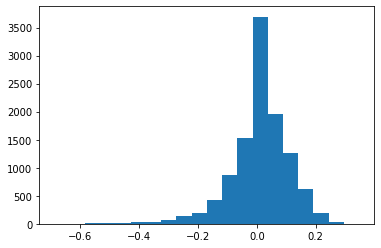

Error absoluto acumulado m: 780.4543


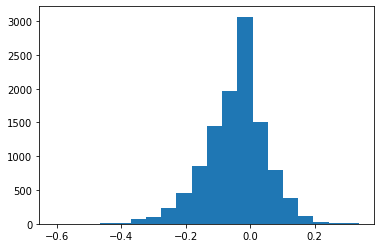

Error absoluto acumulado h: 860.7798


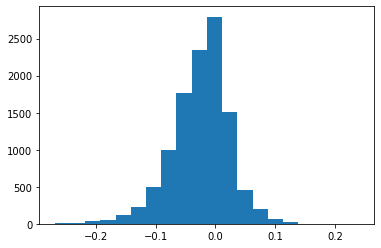

Error absoluto acumulado e: 442.6266


In [17]:
if study == 'XY': 
    e_X = np.zeros(len(ds_test))
    e_Y = np.zeros(len(ds_test))
    X_ae = 0
    Y_ae = 0

    with torch.no_grad():
        model.eval()
        for i in range(0,len(ds_test)):
            # Extract the sample
            x, y = ds_test[i]
            y = y.to('cpu').detach().numpy()
            # Inference
            X, Y = model(x.reshape(1,2000, -1).to(device))
            X, Y = X.to('cpu').detach().numpy(), Y.to('cpu').detach().numpy()
            # Error
            e_X[i] = X - y[0]
            e_Y[i] = Y - y[1]

    plt.hist(e_X, bins=20)
    plt.show()
    print(f'Error absoluto acumulado X: {sum(abs(e_X)):.4f}')
    plt.hist(e_Y, bins=20)
    plt.show()
    print(f'Error absoluto acumulado Y: {sum(abs(e_Y)):.4f}')
else:
    e_m = np.zeros(len(ds_test))
    e_h = np.zeros(len(ds_test))
    e_e = np.zeros(len(ds_test))
    m_ae = 0
    h_ae = 0
    e_ae = 0
    with torch.no_grad():
        model.eval()
        for i in range(0,len(ds_test)):
            # Extract the sample
            x, y = ds_test[i]
            y = y.to('cpu').detach().numpy()
            # Inference
            m, h, e = model(x.reshape(1,2000, -1).to(device))
            m, h, e = m.to('cpu').detach().numpy(), h.to('cpu').detach().numpy(), e.to('cpu').detach().numpy()
            # Error
            e_m[i] = m - y[0]
            e_h[i] = h - y[1]
            e_e[i] = e - y[2]

    plt.hist(e_m, bins=20)
    plt.show()
    print(f'Error absoluto acumulado m: {sum(abs(e_m)):.4f}')
    plt.hist(e_h, bins=20)
    plt.show()
    print(f'Error absoluto acumulado h: {sum(abs(e_h)):.4f}')
    plt.hist(e_e, bins=20)
    plt.show()
    print(f'Error absoluto acumulado e: {sum(abs(e_e)):.4f}')

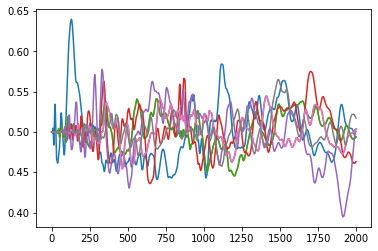

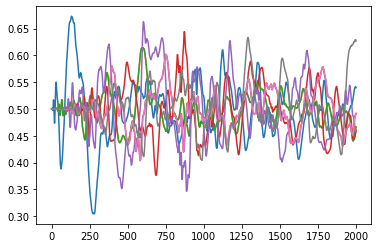

In [ ]:
wng_idx = np.where(abs(e_X) == max(abs(e_X)))[0][0]
wrong_impact = ds_test[wng_idx][0].detach().numpy().reshape(2000, -1)
plt.plot(wrong_impact)
plt.show()
ds_test[wng_idx][1]
idx_test[wng_idx]

wng_idx = np.where(abs(e_Y) == max(abs(e_Y)))[0][0]
wrong_impact = ds_test[wng_idx][0].detach().numpy().reshape(2000, -1)
plt.plot(wrong_impact)

In [ ]:
pred = np.zeros((len(ds_test), 2))
targ = np.zeros((len(ds_test), 2))
for i in range(0,len(ds_test)):
    # Get single impact
    x, y = ds_test[i]
    # Transform y tensor to numpy
    y = y.cpu().detach().numpy()
    # Inference
    X, Y= model(
        x.reshape(1,2000,8).to(device)
    )
    X, Y = X.cpu().detach().numpy()[0], Y.cpu().detach().numpy()[0]
    # Resize XY and load at pred/target matrix
    targ[i,:] = [y[0]*630, y[1]*710]
    pred[i,:] = [X*630, Y*710]

# Save results
np.savetxt('/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/XY/Results/Target_XY_k-0'+str(k)+'.dat', targ, delimiter=',')
np.savetxt('/content/drive/MyDrive/MUSE/S3/CE2/Redes/Multiple_Outputs/XY/Results/Predictions_XY_k-0'+str(k)+'.dat', pred, delimiter=',')
print("CORRECTLY SAVED")

CORRECTLY SAVED
